In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from mlxtend.regressor import StackingRegressor
from scipy.special import erfc
import keras.models
import keras.layers
import tensorflow as tf

# EDA

- ## 같은 행정동의 지하철역 개수 (API 미활용 버전)

y데이터는 강원, 대구, 서울이지만 역과 매매가가 관계가 있을 것 같아서 지하철이 있는 대구와 서울의 역사정보를 가지고 옴

In [ ]:
# y데이터에는 우편번호와 주소가 있는데 -> 우편번호를 행정동으로 바꿈 (외부 데이터 이용)
# 역사정보에는 주소와 위경도가 있는데 -> 주소로 행정동만 전처리해서 가져옴
# 결국 행정동명으로 조인해서 상관관계를 구할 예정
daegu_sub = pd.read_csv('대구지하철1.csv', encoding = "CP949")
seoul_sub = pd.read_csv('서울지하철.csv', encoding = "CP949")

In [ ]:
# 우편번호를 행정동명으로 바꾸는 자료
file = pd.read_csv('전국팔도.txt', delimiter = '\|', engine = 'python')

In [ ]:
# Y데이터에 우편번호에 행정동명을 매칭시킨다.
total_price = pd.merge(apt_data, temp, left_on='우편번호', right_on='우편번호', how='left')
daegu_price = pd.merge(apt_daegu, temp, left_on='우편번호', right_on='우편번호', how='left')
seoul_price = pd.merge(apt_seoul, temp, left_on='우편번호', right_on='우편번호', how='left')

In [ ]:
# 행정동당 아파트의 면적당 매매가를 평균낸다.
mean_price_total = mean_price_total[['행정동명','면적당매매실거래가격']]
daegu_price = mean_price_daegu[['행정동명','면적당매매실거래가격']]
seoul_price = mean_price_seoul[['행정동명','면적당매매실거래가격']]

Y 데이터에서 우편번호 -> 행정동으로 바꾼 행정동과 지하철 데이터의 행정동명이 일치하지 않는 데이터 존재  
EX) 교동 VS 교1동

그래서 지하철 데이터에서 안 맞는 데이터를 하나하나 고침

In [ ]:
# 역사정보와 Y데이터를 행정동을 기준으로 합침
total = pd.merge(mean_price_total, sub, how = 'left')
daegu = pd.merge(mean_price_daegu, daegu_sub, how = 'left')
seoul = pd.merge(mean_price_seoul, seoul_sub, how = 'left')

In [ ]:
total.corr(method = 'pearson') # 강원도도 포함된 데이터의 상관관계 0.27로 그렇게 좋아보이지 않음

In [ ]:
daegu.corr(method='pearson') # 대구 데이터만 상관관계 0.19 > bad

In [ ]:
seoul.corr(method = 'pearson') # 서울 데이터만 상관관계 -0.22 > bad

같은 행정동안에 있는 역만 세기에는 옆 행정동의 역이 더 가까울 수도 있음  
적절한 변수가 아닐것으로 판단

- ## 같은 행정동 내 공원 수 (API 미활용 버전)

In [ ]:
gangwon_park = pd.read_csv("강원도공원.csv",encoding = 'euc-kr')
daegu_park = pd.read_csv("대구공원.csv",encoding = 'euc-kr')
seoul_park = pd.read_csv("서울공원.csv",encoding = 'euc-kr')

In [ ]:
price_sub = pd.read_csv("price_sub.csv",encoding = 'euc-kr')

In [ ]:
# 세 지역의 공원데이터를 합침
park = pd.concat([gangwon_park, daegu_park, seoul_park])

In [ ]:
# 공원 데이터와 매매가를 행정동 기준으로 조인
price_sub_park = pd.merge(price_sub, park, how = 'left')

In [ ]:
price_sub_park.corr(method = 'pearson') # 관계가 어느정도 있을 것으로 예상했지만 -0.06으로 대참사

In [ ]:
plt.scatter(price_sub_park['공원수'],price_sub_park['면적당매매실거래가격'],c='green')

플랏을 보니 한 행정동에 이상하게 공원이 많음 >> 놀이터 같은 공원도 공원으로 포함 돼 있음 >> 공원 면적 고려해 다시 전처리

In [ ]:
mean_price = pd.read_csv("공원정보_공원수/mean_price.csv",encoding = 'euc-kr')
seoul_parks =pd.read_csv("공원정보_공원수/seoul_park.csv",encoding = 'euc-kr')
daegu_parks = pd.read_csv("공원정보_공원수/daegu_park.csv",encoding = 'euc-kr')
gangwon_parks = pd.read_csv("공원정보_공원수/gangwon_park.csv",encoding = 'euc-kr')

In [ ]:
# 세 지역의 공원데이터를 합침
parks = pd.concat([gangwon_parks, daegu_parks, seoul_parks])

In [ ]:
# 행정동당 공원수
parks_sum = pd.DataFrame(data = parks.groupby('행정동명')['공원수'].size())

In [ ]:
# 공원 데이터와 매매가를 행정동 기준으로 조인
price_park = pd.merge(mean_prices, parks_sum,left_on = '행정동명', right_on = '행정동명', how = 'left')

In [ ]:
# NA값은 0으로 처리
price_parks = price_park.fillna(0)

In [ ]:
price_parks.corr(method = 'pearson') # 상관관계 -0.09 > bad

- ## API 활용 버전 아파트 반경 내 주요시설 EDA

주소를 좌표로 변환해주는 코드, 좌표 반경 몇 KM 이내 시설물 검색가능한 API 코드 작성

In [ ]:
import requests; from urllib.parse import urlparse
import pandas as pd
import geopandas

In [ ]:
# address에 주소를 넣으면 좌표 반환 example
address = "강원도 평창군 대관령면 올림픽로 2020"
url = "https://dapi.kakao.com/v2/local/search/address.json?&query=" + address
result = requests.get(urlparse(url).geturl(),
                      headers={"Authorization":"KakaoAK e7667481e55296cab7a7c8e7528b4023"})
json_obj = result.json()

In [ ]:
# 반환한 좌표를 보여주는 함수
def address_to_latlons(address):
    url = "https://dapi.kakao.com/v2/local/search/address.json?&query=" + address
    result = requests.get(urlparse(url).geturl(),
                          headers={"Authorization":"KakaoAK e7667481e55296cab7a7c8e7528b4023"})
    json_obj = result.json()
    for document in json_obj['documents']:
        global vals
        vals = [document['building_name'], document['y'], document['x']]
    return vals

In [ ]:
# 좌표와 반경, 시설물 keyword를 입력하면 시설물 수를 알 수 있는 함수
def point_to_num(y,x,radius,keyword):
    url = "https://dapi.kakao.com/v2/local/search/keyword.json?&y=" + y + "&x=" + x + "&radius=" + radius + "&query=" + keyword
    result = requests.get(urlparse(url).geturl(),
                      headers={"Authorization":"KakaoAK e7667481e55296cab7a7c8e7528b4023"})
    json_obj = result.json()
    global val
    val = json_obj['meta']['pageable_count']
    return val

- ## 지하철역 수와 매매가의 상관관계 (API활용 버전)

지하철은 대구와 서울 밖에 없기 때문에 대구아파트의 주소, 서울아파트의 주소만 따와서 지하철 수 파악 후 지하철이 있는 도시들 상관관계와 강원도를 합친 데이터의 상관관계를 파악하고자 함

In [ ]:
apt_seoul = pd.read_csv("기웅/apt_seoul.csv",encoding = 'euc-kr')
apt_daegu = pd.read_csv("기웅/apt_daegu.csv",encoding = 'euc-kr')
apt = pd.read_csv("기웅/apt.csv",encoding = 'euc-kr')

In [ ]:
#아파트별로 주소 남김
apt_daegu2 = apt_daegu1.drop_duplicates(['아파트명'])
apt_seoul2 = apt_seoul1.drop_duplicates(['아파트명'])

In [ ]:
a = []                                                 # 서울데이터 주소를 위도 경도 변환
for address in apt_seoul2['아파트주소']:
    a.append(address_to_latlons(address))
    
apt_seoul_point = pd.DataFrame(a, columns = ['아파트명', '아파트주소', '위도', '경도'])

In [ ]:
c = []                                                 # 대구데이터 주소를 위도 경도 변환
for address in apt_daegu2['아파트주소']:
    c.append(address_to_latlons(address))
    
apt_daegu_point = pd.DataFrame(c, columns = ['아파트명', '아파트주소', '위도', '경도'])

In [ ]:
b = []                                                # 서울아파트 좌표로 주위 지하철 수 구함
for i in range(0,len(apt_seoul_point['아파트명'])): 
    b.append(point_to_num(apt_seoul_point['위도'][i], apt_seoul_point['경도'][i], '500', '지하철'))

In [ ]:
apt_seoul_point['지하철수1'] = b # 서울 y데이터에 붙임

In [ ]:
bb = []                                               # 대구아파트 좌표로 주위 지하철 수 구함
for i in range(0,len(apt_daegu_point['아파트명'])):
    bb.append(point_to_num(apt_daegu_point['위도'][i], apt_daegu_point['경도'][i], '1000', '지하철'))

In [ ]:
apt_daegu_point['지하철수1'] = bb  # 대구 y데이터에 붙임 

In [ ]:
#서울 대구 지하철수 데이터 합침
apt_near_sub = pd.concat([apt_seoul_point, apt_daegu_point])

Y 데이터에서 우편번호 -> 행정동으로 바꾼 행정동과 지하철 데이터의 행정동명이 일치하지 않는 데이터 존재

해당 데이터 전처리 후 상관관계 계산

In [ ]:
# 강원도 미포함 데이터
apt_sub.corr(method = 'pearson')  # 상관관계가 0.2 > bad

In [ ]:
# 강원도 포함 데이터
apt_sub_1.corr(method = 'pearson') # 상관관계가 0.2 > bad

파라미터 반경(radius)을 바꿔가며 상관관계를 봄  
앞의 과정 반복 후 500M, 1KM, 2KM, 3KM 중 2km 이내 지하철 수가 가장 높은 상관관계 0.41을 보였다.

- ## 공원 수 (앞선 EDA에서 관계가 있을 것이라 판단) - 변수 선택 (API 활용)

3KM, 2.5KM, 2KM, 2.7KM, 1.5KM 2.8KM, 2.6KM 이내 공원수 중 2.6KM 이내 공원수의 상관관계가 0.36정도로 높아서 변수로 선택

*API를 활용한 지하철 수 EDA와 코드가 동일하여 해당 부분 코드는 제외하였습니다.*

- ## 학교 수 - 변수 선택 (API 활용)

500, 700, 1000, 900 중 1KM가 상관관계 0.37로 가장 높아서 변수로 선택

*API를 활용한 지하철 수 EDA와 코드가 동일하여 해당 부분 코드는 제외하였습니다.*

- ## 모텔 수 - 변수 선택되지 않음 (API 활용)

1000, 2000, 1500 M 중 2KM 이내가 가장 높았으나 0.16이라 쓸모가 없을 것이라 판단

*API를 활용한 지하철 수 EDA와 코드가 동일하여 해당 부분 코드는 제외하였습니다.*

- ## 술집 수 ( 술집을 검색하면 나오는 시설물의 수 ) - 변수 선택되지 않음 (API 활용)

1000, 700, 500M 중 가장 높은 상관관계가 0.19 라서 쓸모가 없을 것이라 판단

*API를 활용한 지하철 수 EDA와 코드가 동일하여 해당 부분 코드는 제외하였습니다.*

- ## 대형마트 수 ( 3KM 정도가 차타고 10분? 정도 걸림) - 변수 선택 (API 활용)

2,3,4,5,6,7,8 KM 이내 조사 한 것 중에서 8KM 이내 대형마트 수 상관관계가 0.52까지 올라서 변수로 선택

*API를 활용한 지하철 수 EDA와 코드가 동일하여 해당 부분 코드는 제외하였습니다.*

 - ## 편의점 수 - 변수 선택되지 않음 (API 활용)

300, 500, 1000, 800M 중 가장 높았던 상관관계가 0.27이라서 변수로 선택하지 않음

*API를 활용한 지하철 수 EDA와 코드가 동일하여 해당 부분 코드는 제외하였습니다.*

- ## 감정평가금액, 최소매각가격

In [ ]:
disposal = pd.read_csv('매각결과.csv', engine='python')
y = pd.read_csv('아파트 일반정보 및 시세.csv', engine='python')

In [ ]:
# 위 변수 중, 필요한 것만 남기기

disposal = disposal.loc[:,['기준년월','물건번호용도내용','소재지및내역내용','감정평가금액','최소매각가격']]

y['y'] = y['최근매매실거래가격'] / y['아파트면적값']
y = y.loc[:,['기준년월','우편번호','아파트명','y']]

In [ ]:
# 중복값 삭제

disposal = disposal.drop_duplicates().reset_index(drop=True)

In [ ]:
# 물건용도 종류를 알아보고자, 정규표현식을 사용해 문자열만 가져옴!

import re

disposal['물건용도'] = '-'
for i in range(len(disposal)) :
    disposal.loc[i,'물건용도'] = re.compile('[가-힣]+').findall(disposal.loc[i,'물건번호용도내용'])

disposal = disposal.loc[:,['기준년월','우편번호','물건용도','감정평가금액','최소매각가격']]

아래의 결과와 같이

- 매각 물건 종류가 매우 다양함
- 매각 물건 종류 별로 감정평가금액/최소매각가격의 양상이 매우 다름

In [ ]:
disposal.groupby('물건용도').mean().loc[:,['감정평가금액','최소매각가격']]

그래서 감정평가금액과 최소매각가격을 "물건 용도별로" 나눠 변수화하기로 결정함

In [ ]:
disposal_group = disposal.groupby(['기준년월','우편번호','물건용도']).mean().reset_index()

In [ ]:
disposal_group.head()

물건 용도별로 나누기 위해서는 '감정평가금액_아파트', '감정평가금액_임야' 등의 형식이어야 함

> 따라서 pivot_table method를 이용해 변수화

In [ ]:
disposal_group.pivot_table(index=['우편번호'], columns='물건용도', values='감정평가금액').reset_index()

In [ ]:
disposal_group.pivot_table(index=['우편번호'], columns='물건용도', values='최소매각가격').reset_index()

그런데 결측값의 비율이 매우 높다.

In [ ]:
print(disposal_group.pivot_table(index=['우편번호'], columns='물건용도', values='감정평가금액').reset_index().shape)
print('-------------------------------')
disposal_group.pivot_table(index=['우편번호'], columns='물건용도', values='감정평가금액').reset_index().isnull().sum()

709개의 행에 결측값이 변수 별로 500-700개 존재

결론
- 물건 용도 별로 나누지 않고 합치기엔 : 용도 별 값의 양상이 너무 달라서 의미 없는 변수가 됨
- 물건 용도 별로 나눠서 변수화하기엔 : 결측값이 너무 많아서 의미 없는 변수
- 독립 변수에서 제외

- ## 시군구간 이동자 수

In [ ]:
moving_num = pd.read_csv('시군별이동자수.csv', engine='python')
y = pd.read_csv('아파트 일반정보 및 시세.csv', engine='python')

In [ ]:
# 이동자 수 데이터가 시/구에 한정되어 있기 때문에, y 데이터도 시/구로 주소를 맞춰주기

y['시.구'] = '-'

for i in range(len(y)) :
    y.loc[i,'시.구'] = y.loc[i,'아파트주소'].split()[1]

In [ ]:
# 필요한 열만 남기기

y['y'] = y['y'] = y['최근매매실거래가격'] / y['아파트면적값']
y = y.loc[:,['기준년월','시.구','y']]

In [ ]:
# 기준년월, 지역 기준으로 조인하여 y와의 상관관계 파악

moving_num.merge(y, left_on=['기준년월','매매지역명'], right_on=['기준년월','시.구']).corr().loc[:,'y']

'시군구간' 전입/전출 세대 수가 유의한 것으로 보임

> 따라서, 기준년월에 해당하는 시군구간 전출 - 전입 세대 수를 변수에 추가함

In [ ]:
# 시군구간 전출 - 전입 세대 수 변수화

moving_num['moving_num'] = moving_num['시군구간전출세대수'] - moving_num['시군구간전입세대수']

In [ ]:
# 필요한 열만 남기기

moving_num = moving_num.loc[:,['기준년월','매매지역명','moving_num']]

- ## 부대시설

In [ ]:
pd.set_option('display.max_row', 500)
y_value = pd.read_csv("C:/Users/LENOVO/Downloads/데이터마이닝프로젝트/기웅/아파트 일반정보 및 시세.csv",encoding='CP949')

pd.options.display.float_format = '{:.2f}'.format
y_value['평당매매실거래가격']=y_value['최근매매실거래가격']/y_value['아파트면적값']

In [ ]:
afc=pd.read_csv("C:/Users/LENOVO/Downloads/데이터마이닝프로젝트/기웅/아파트 부대시설 정보.csv",encoding='CP949')

In [ ]:
import collections as collections

pd.set_option('display.max_row', 500)
y_value=y_value[['기준년월','우편번호','아파트면적값','최근매매실거래가격','평당매매실거래가격','아파트주소']]

# 관리사무소, 어린이놀이터 등 ','로 나열된 부대시설 개수를 파악하기 위해 ','를 기준으로 문자열 split
prac=pd.merge(y_value,afc, on=['우편번호','기준년월','아파트주소'])
prac=prac.drop(prac.columns[[15]],axis=1)
prac['부대시설갯수']=prac.부대시설명.str.count(',')+1
prac['난방_매핑']=prac['난방명'].factorize()[0]

In [ ]:
# 높은 상관관계를 보임 -> 변수로 선택
corr=prac.corr(method='pearson')

In [ ]:
# 부대시설 종류 별로 더미변수 생성

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import openpyxl

pd.set_option('display.max_rows', 500)
pval=prac[['기준년월','우편번호','아파트주소','아파트명','평당매매실거래가격','세대당주차대수','아파트준공일자','CCTV수','부대시설갯수','승강기수','부대시설명']]
list=pval['부대시설명'].tolist()

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(list)
cv.get_feature_names()

onehot=pd.DataFrame(X.A, columns=cv.get_feature_names())
result=pd.concat([pval,onehot],axis=1)

- ## 가게 매출과 면적당 매매가의 상관관계 (변수로 선택하지 않음)

In [ ]:
# 우체국 DB를 통해 전국의 행정동, 지역 구분에 따른 우편번호 텍스트 파일
file = pd.read_csv('./전국팔도.txt', delimiter = '\|')

In [ ]:
full_data = pd.read_csv("거래내역_201904.csv" , encoding = 'CP949')

In [ ]:
# 매출금액을 가게별로 그룹화해 합계처리
sum = pd.DataFrame(data = full_data.groupby('가맹점신우편번호')['매출금액'].sum())

In [ ]:
temp = file[['우편번호','행정동명']]

In [ ]:
# 매출금액 데이터와 우편번호 데이터를 우편번호 기준으로 조인
total = pd.merge(sum, temp, left_on='가맹점신우편번호', right_on='우편번호', how='inner')

In [ ]:
# 필요한 열만 남기기, NA 전처리
total = total[['행정동명','매출금액']]
total.dropna(axis=0, how='any', inplace=True)

total_sales=total.drop_duplicates(['행정동명', '매출금액'], keep='first')

In [ ]:
# 같은 가게에 해당하는 거래내역을 그룹화해 합계처리
total_sales = pd.DataFrame(data = total_sales.groupby('행정동명')['매출금액'].sum())

In [ ]:
# 최근매매실거래 가격을 아파트 면적으로 나눔
recent_price = pd.read_csv("아파트 일반정보 및 시세.csv", encoding = 'CP949')
add_col = recent_price["최근매매실거래가격"]/recent_price["아파트면적값"]
recent_price["면적당최근매매실거래가"] = add_col

In [ ]:
# 같은 아파트에 해당하는 행들의 값들을 그룹화해 평균 처리
mean_price = pd.DataFrame(data = recent_price.groupby('우편번호')['면적당최근매매실거래가'].mean())
mean_price.reset_index(inplace=True)

In [ ]:
# y데이터와 행정동명을 우편번호 기준으로 조인
total_price = pd.merge(mean_price, temp, left_on='우편번호', right_on='우편번호', how='inner')
total_price = total_price[['행정동명','면적당최근매매실거래가']]
total_price.dropna(axis=0, how='any', inplace=True)

# 중복값 제거
total_price=total_price.drop_duplicates(['행정동명', '면적당최근매매실거래가'], keep='first')

In [ ]:
# 한 행정동의 포함되는 우편번호들의 매매실거래가를 평균으로 groupby함
total_price = pd.DataFrame(data = total_price.groupby('행정동명')['면적당최근매매실거래가'].mean())

In [ ]:
# 행정동 내 매출액과 y 데이터를 행정동 기준으로 조인 후, scatter plot으로 상관관계 파악
df = pd.merge(total_price, total_sales, left_on='행정동명', right_on='행정동명', how='inner')
plt.scatter(df['매출금액'],df['면적당최근매매실거래가'],c='coral')

In [ ]:
# raw data로는 눈에 띄는 상관관계가 보이지 않아, min max scaling 후 상관관계 파악
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[:] = scaler.fit_transform(df[:])

plt.scatter(np.log(df['매출금액']),np.log(df['면적당최근매매실거래가']),c='green')

상관관계가 충분히 유의미하지 않아, 독립변수에서 제외함.

각 지역에 있는 모든 가게의 매출을 집계한 것이 아니라 일부 가게만 집계한 것이기 때문에 지역마다 매출금액의 차이가 존재. 이에 유의한 상관관계를 보이지 않는다 판단

- ## 인구밀도

In [ ]:
temp1 = pd.read_csv('./강릉시.txt',delimiter = '\t', thousands = ',')
temp2 = pd.read_csv('./남구.txt',delimiter = '\t', thousands = ',')
temp3 = pd.read_csv('./달서구.txt',delimiter = '\t', thousands = ',')
temp4 = pd.read_csv('./달성군.txt',delimiter = '\t', thousands = ',')
temp5 = pd.read_csv('./동구.txt',delimiter = '\t', thousands = ',')
temp6 = pd.read_csv('./동해시.txt',delimiter = '\t', thousands = ',')
temp7 = pd.read_csv('./북구.txt',delimiter = '\t', thousands = ',')
temp8 = pd.read_csv('./삼척시.txt',delimiter = '\t', thousands = ',')
temp9 = pd.read_csv('./서구.txt',delimiter = '\t', thousands = ',')
temp10 = pd.read_csv('./속초시.txt',delimiter = '\t', thousands = ',')
temp11 = pd.read_csv('./수성구.txt',delimiter = '\t', thousands = ',')
temp12 = pd.read_csv('./원주시.txt',delimiter = '\t', thousands = ',')
temp13 = pd.read_csv('./종로구.txt',delimiter = '\t', thousands = ',')
temp14 = pd.read_csv('./중구.txt',delimiter = '\t', thousands = ',')
temp15 = pd.read_csv('./춘천시.txt',delimiter = '\t', thousands = ',')
temp16 = pd.read_csv('./태백시.txt',delimiter = '\t', thousands = ',')
temp17 = pd.read_csv('./홍천군.txt',delimiter = '\t', thousands = ',')

In [ ]:
total_density = pd.concat([temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15,temp16,temp17], ignore_index=True)

In [ ]:
# 인구/면적으로 인구밀도 변수 추가
total_density['인구'] = list(map(float,total_density['인구'] ))
total_density['면적'] = list(map(float,total_density['면적'] ))

add_col3 = total_density['인구'] / total_density['면적']
total_density['인구밀도'] = add_col3

In [ ]:
# 인구밀도와 y 데이터의 상관관계를 보기 위해 행정동 기준으로 조인
df2 = pd.merge(total_price, total_density, left_on='행정동명', right_on='행정동', how='inner')
df2.corr(method='pearson')

In [ ]:
plt.scatter(df2['ㅇ'],df2['면적당최근매매실거래가'],c='coral')

인구밀도와 매매실거래가의 상관관계 : 0.46 > good

- ## 거래건수

기준년월별(201904,201905,202004,202005) 아파트 거래건수, 오피스텔 거래건수, 주택 거래건수

세 변수 모두 y값과 유의한 상관관계를 보이지만, 세 변수 간의 다중공선성 존재
> quantile regression 결과를 근거로 주택 거래건수만 남기고, 나머지 두 변수는 제거

*해당 EDA는 초반에 R로 진행하여 코드 제외하였습니다.*

- ## 주식지표

타 변수들과 다르게 주차별로 기록되어있어, week를 기준으로 y 데이터와 조인해 관계를 파악

여러 지표 중, 주가 수익 비율 / 주가 현금 흐름 비율이 유의미해 독립 변수에 포함

*해당 EDA는 초반에 R로 진행하여 코드 제외하였습니다.*

# 조인 과정 코드

EDA를 마친 뒤, 모든 독립변수들을 하나의 데이터로 조인함

*단순 pd.merge이므로 해당 코드는 제외하였습니다.*

# Modeling

In [2]:
df = pd.read_csv('final2.csv',encoding = 'euc-kr')
df = shuffle(df) # 좀 더 랜덤한 학습을 위해 데이터를 섞어줌

In [3]:
# y 값이 한쪽에 치우친 문제를 해결하기 위해 y에 로그를 씌워 분석 진행
df.Y = np.log(df.Y)

train = df.loc[(df.기준년월==201904)|(df.기준년월==201905),
               ['아파트세대수', '아파트동수', '아파트면적값', '서울특별시', '강원도', '대구광역시', '면적', '인구', '세대', '대형마트수_8km이내',
                '지하철수_2km이내', '학교수_1km이내', '공원수_2.6km이내', '인구밀도', '세대당주차대수', '아파트준공일자',
                'CCTV수','부대시설갯수', '승강기수', '관리사무소', '노인정', '문고', '보육시설', '어린이놀이터', '유치원',
                '자전거보관소', '주민공동시설', '커뮤니티공간', '휴게시설', '주택거래건수', 
                'mean.주가수익비율', 'mean.주가현금흐름비율', 'moving_num','Y']]
# hyper parameter 조절 및 최적의 모델을 선정하기 위한 validation set 분리
valid = df.loc[df.기준년월==202004, ['아파트세대수', '아파트동수', '아파트면적값', '서울특별시', '강원도', '대구광역시', '면적', '인구', '세대', '대형마트수_8km이내',
                                 '지하철수_2km이내', '학교수_1km이내', '공원수_2.6km이내', '인구밀도', '세대당주차대수', '아파트준공일자',
                                 'CCTV수','부대시설갯수', '승강기수', '관리사무소', '노인정', '문고', '보육시설', '어린이놀이터', '유치원',
                                 '자전거보관소', '주민공동시설', '커뮤니티공간', '휴게시설', '주택거래건수', 
                                 'mean.주가수익비율', 'mean.주가현금흐름비율', 'moving_num','Y']]
test = df.loc[df.기준년월==202005, ['아파트세대수', '아파트동수', '아파트면적값', '서울특별시', '강원도', '대구광역시', '면적', '인구', '세대', '대형마트수_8km이내',
                                 '지하철수_2km이내', '학교수_1km이내', '공원수_2.6km이내', '인구밀도', '세대당주차대수', '아파트준공일자',
                                 'CCTV수','부대시설갯수', '승강기수', '관리사무소', '노인정', '문고', '보육시설', '어린이놀이터', '유치원',
                                 '자전거보관소', '주민공동시설', '커뮤니티공간', '휴게시설', '주택거래건수', 
                                 'mean.주가수익비율', 'mean.주가현금흐름비율', 'moving_num','Y']]

In [4]:
# 독립변수 + 종속변수로 나누는 함수 생성

def get_xy(data) :
    x = data.drop('Y', axis=1)
    y = data.Y
    return x,y

train_x, train_y = get_xy(train)
valid_x, valid_y = get_xy(valid)
test_x, test_y = get_xy(test)

# deep learning fitting

- 통계적 가정을 만족시키기 위해 y에 로그를 씌워서 학습시킴
- n이 상대적으로 적다고 판단하여, 1) 미니 배치를 사용하지 않고 2) gradient descent optimizer 사용 3) hidden layer 1개만 사용
- learning rate는 0.001,0.01,0.05 중 가장 안정적인 예측을 하는 0.01로 선택


- 처음엔 relu activation function을 이용했으나, 노드가 죽는 경우 발생 -> 학습이 되지 않음  
- 해결책 1 : batch normalization
- 해결책 2 : activation function을 selu로 변경 (selu activation fn + sequential api가 성능이 좋다고 알려져있음)  

In [ ]:
# selu function

alpha_0_1 = -np.sqrt(2/np.pi) / ( erfc(1/np.sqrt(2)) * np.exp(1/2) -1 )
scale_0_1 = ( 1 - erfc(1/np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2*np.pi) * ( 2 * erfc(np.sqrt(2))*np.e**2 + 
                                                                           np.pi*erfc(1/np.sqrt(2))**2*np.e -
                                                                           2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e) +
                                                                           np.pi + 2 )**(-1/2)

def selu(z, scale = scale_0_1, alpha = alpha_0_1) :
    return scale * tf.where(z>=0.0, z, alpha*tf.nn.elu(z))

In [ ]:
def build_model() :
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(30, activation=selu, input_shape=(train_x.shape[1],)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation=selu))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1))
    opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

train_y = np.log(train_y)

model = build_model()
result = model.fit(train_x, train_y, epochs=100, validation_split=0.33, batch_size=1, verbose=0)

In [ ]:
# overfitting 확인

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
# 모델 정교화

from keras import regularizers

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

def build_model() :
    model = tf.keras.models.Sequential()
    
    ## input layer
    model.add(tf.keras.layers.Dense(30, activation=selu, input_shape=(train_x.shape[1],)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    ## hidden layer
    model.add(tf.keras.layers.Dense(15, activation=selu))
    model.add(tf.keras.layers.BatchNormalization())
              
    ## output layer
    model.add(tf.keras.layers.Dense(1))
    
    ## model compile
    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

train_y = np.log(train.y)

model = build_model()
result = model.fit(train_x, train_y, epochs=1000, validation_split=0.5, batch_size=1, callbacks=[callback], verbose=0)

In [ ]:
prediction = pd.DataFrame(np.exp(model.predict(valid_x)))
prediction.columns = ['pred']
prediction['true'] = valid.y.reset_index(drop=True)

hyper parameter를 다양하게 조절하여 적합시켜보았으나, 성능이 향상되지 않았음 + overfitting

해당 데이터는 deep learning 모델엔 부적절하다고 판단하여, machine learning 모델을 적용시켜보기로 함

# 다양한 machine learning - regression 모델 적합시켜보기

- 별도의 hyper parameter 없이 validation set R square를 통해 대략적인 모델의 적절성만 파악  
- 이후 괜찮은 모델 몇개만 골라서 hyper parameter tuning 진행

*해당 적합 결과는 ppt에 명시해두었습니다.*

## 성능 높은 모델 hyper parameter tuning

- ## **그래디언트 부스팅 회귀**

In [5]:
param_gbrt={'n_estimators':[100,200,300,400,500], 
            'learning_rate': [0.1,0.05,0.01],
            'max_depth':[2,5,8,10],
            'max_features':[5,10,15,20,25,30]} 

search_gbrt = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=0), cv=5, param_distributions=param_gbrt, n_jobs=-1, n_iter=30)
search_gbrt.fit(train_x, train_y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [6]:
gbrt_best = GradientBoostingRegressor(random_state=0, max_depth=search_gbrt.best_params_['max_depth'],
                                      max_features=search_gbrt.best_params_['max_features'],
                                      n_estimators=search_gbrt.best_params_['n_estimators'],
                                     learning_rate=search_gbrt.best_params_['learning_rate'])
gbrt_best.fit(train_x, train_y)

print("train set R^2 : {:.3f}".format(gbrt_best.score(train_x, train_y)))
print("valid set R^2 : {:.3f}".format(gbrt_best.score(valid_x, valid_y)))

train set R^2 : 0.999
valid set R^2 : 0.846


- ## **k neighbors 회귀**

In [9]:
param_knn={'n_neighbors':range(1,200)}

search_knn = RandomizedSearchCV(estimator=KNeighborsRegressor(), cv=5, param_distributions=param_knn, n_jobs=-1, n_iter=100)
search_knn.fit(train_x, train_y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'n_neighbors': range(1, 200)},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [10]:
kn_best = KNeighborsRegressor(n_neighbors=search_knn.best_params_['n_neighbors'])
kn_best.fit(train_x, train_y)

print("train set R^2 : {:.3f}".format(kn_best.score(train_x, train_y)))
print("valid set R^2 : {:.3f}".format(kn_best.score(valid_x, valid_y)))

train set R^2 : 0.998
valid set R^2 : 0.932


# voting regression

- 아무래도 train set과 validation set 성능의 간극을 좁힐 수 없어  
- 가장 성능이 좋게 나온 knn을 base estimator로 하여 세 앙상블 모델(pasting, bagging, boosting)을 만듦

*아래 코드는 스태킹 모델의 한계로 최종 모델에 선택되지 않음*

In [11]:
from xgboost import XGBRegressor

In [12]:
# 그 전에 두개의 부스팅 모델을 기반으로 스태킹도 시도해보았지만, 성능이 좋지 않아 앙상블 모델은 세개(pasting, bagging, boosting)만 사용

GBC = GradientBoostingRegressor()
gb_param_grid = {'n_estimators' : [100,200,300,400,500],'learning_rate': [0.1, 0.05, 0.01],'max_depth': [2,4,6], 'max_features': [0.3, 0.1,0.5,0.9] }
gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
gsGBC.fit(train_x, train_y)
GBC_best = gsGBC.best_estimator_

In [13]:
XGB = XGBRegressor()
xgb_param_grid = {'learning_rate': [1,0.1,0.01,0.001],'n_estimators': [50, 100, 200, 500], 'max_depth' : [2,4,6]}
gsXGB = GridSearchCV(XGB, param_grid = xgb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
gsXGB.fit(train_x, train_y)
XGB_best = gsXGB.best_estimator_

In [14]:
st_re = StackingRegressor(regressors=[XGB_best, GBC_best], meta_regressor=RandomForestRegressor())
st_re.fit(train_x, train_y)

print("train set R^2 : {:.3f}".format(st_re.score(train_x, train_y)))
print("valid set R^2 : {:.3f}".format(st_re.score(valid_x, valid_y)))

C:\Users\taeni\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train set R^2 : 0.999
valid set R^2 : 0.798


## base linear model : knn regression

In [5]:
kn_reg = KNeighborsRegressor(n_neighbors=6)

## train + valid (더이상 성능 확인 필요x)

In [6]:
train = df.loc[df.기준년월!=202005, ['아파트세대수', '아파트동수', '아파트면적값', '서울특별시', '강원도', '대구광역시', '면적', '인구', '세대', '대형마트수_8km이내',
                                 '지하철수_2km이내', '학교수_1km이내', '공원수_2.6km이내', '인구밀도', '세대당주차대수', '아파트준공일자',
                                 'CCTV수','부대시설갯수', '승강기수', '관리사무소', '노인정', '문고', '보육시설', '어린이놀이터', '유치원',
                                 '자전거보관소', '주민공동시설', '커뮤니티공간', '휴게시설', '주택거래건수', 
                                 'mean.주가수익비율', 'mean.주가현금흐름비율', 'moving_num','Y']]
test = df.loc[df.기준년월==202005, ['아파트세대수', '아파트동수', '아파트면적값', '서울특별시', '강원도', '대구광역시', '면적', '인구', '세대', '대형마트수_8km이내',
                                 '지하철수_2km이내', '학교수_1km이내', '공원수_2.6km이내', '인구밀도', '세대당주차대수', '아파트준공일자',
                                 'CCTV수','부대시설갯수', '승강기수', '관리사무소', '노인정', '문고', '보육시설', '어린이놀이터', '유치원',
                                 '자전거보관소', '주민공동시설', '커뮤니티공간', '휴게시설', '주택거래건수', 
                                 'mean.주가수익비율', 'mean.주가현금흐름비율', 'moving_num','Y']]

train_x, train_y = get_xy(train)
test_x, test_y = get_xy(test)


In [ ]:
## voting regressor

In [10]:
pas_reg = BaggingRegressor(base_estimator = kn_reg, bootstrap=False, random_state=0)
bag_reg = BaggingRegressor(base_estimator = kn_reg, bootstrap=True, random_state=0)
ada_reg = AdaBoostRegressor(base_estimator = kn_reg, random_state=0)

param_ensemble = {'n_estimators':[300,400,500], 'max_features':[20,25,30]} 
param_adaboost = {'n_estimators':[300,400,500], 'learning_rate':[0.01,0.1,0.5]} 

def random_cv(obj, grid) :
    search_method = RandomizedSearchCV(estimator=obj, cv=5, n_iter = 8,param_distributions=grid, n_jobs=-1)
    search_method.fit(train_x, train_y)
    best = search_method.best_params_
    return best

In [ ]:
pas_best = random_cv(pas_reg, param_ensemble)
pas_best = BaggingRegressor(base_estimator = kn_reg, bootstrap=False, random_state=0, n_estimators=pas_best['n_estimators'], max_features=pas_best['max_features'])

In [ ]:
bag_best = random_cv(bag_reg, param_ensemble)
bag_best = BaggingRegressor(base_estimator = kn_reg, bootstrap=True, random_state=0, n_estimators=bag_best['n_estimators'], max_features=bag_best['max_features'])

In [ ]:
ada_best = random_cv(ada_reg, param_adaboost)
ada_best = AdaBoostRegressor(base_estimator = kn_reg, random_state=0, n_estimators=ada_best['n_estimators'], learning_rate=ada_best['learning_rate'])

In [9]:
voting_reg = VotingRegressor(
    estimators=[('bag', bag_best), ('pas', pas_best),('ada', ada_best)])

voting_reg.fit(train_x, train_y)

VotingRegressor(estimators=[('bag',
                             BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                                                 leaf_size=30,
                                                                                 metric='minkowski',
                                                                                 metric_params=None,
                                                                                 n_jobs=None,
                                                                                 n_neighbors=6,
                                                                                 p=2,
                                                                                 weights='uniform'),
                                              bootstrap=True,
                                              bootstrap_features=False,
                                              max_feature

# check and eliminate outlier obs. from train model residual

In [10]:
train['pred'] = voting_reg.predict(train_x)
train['resd'] = np.abs(train.Y - train.pred)

In [11]:
train.resd.describe()

count    3.331200e+04
mean     3.303517e-02
std      2.760599e-02
min      1.065814e-14
25%      1.186480e-02
50%      2.726193e-02
75%      4.691731e-02
max      3.372404e-01
Name: resd, dtype: float64

In [36]:
# 약 6% 잘라냄
0.03303517 + 1.645*0.02760599

0.07844702355

In [12]:
train = train.loc[train.resd < 0.07845, : ]

train_x = train.drop(['Y','pred','resd'], axis=1)
train_y = train.Y

In [34]:
train.describe()

,아파트세대수,아파트동수,아파트면적값,서울특별시,강원도,대구광역시,면적,인구,세대,대형마트수_8km이내,...,주민공동시설,커뮤니티공간,휴게시설,주택거래건수,mean.주가수익비율,mean.주가현금흐름비율,moving_num,Y,pred,resd
count,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,...,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,31205.000000,3.120500e+04
mean,185.757186,6.541676,87.443722,0.020061,0.245506,0.734434,5.346983,24284.920453,9345.789953,14.604679,...,0.510687,0.155584,0.283833,68.624483,17.290132,13.273903,-152.944656,14.964757,14.964467,2.831414e-02
std,168.592635,4.233275,31.506607,0.140211,0.430393,0.441641,8.887122,14800.760364,5125.140617,8.041859,...,0.499894,0.362466,0.450864,39.781237,0.582182,0.642134,519.277883,0.478191,0.475100,2.012605e-02
min,6.000000,1.000000,12.650000,0.000000,0.000000,0.000000,0.230000,12.218000,6.140000,0.000000,...,0.000000,0.000000,0.000000,4.000000,16.205070,11.898776,-1802.000000,13.381912,13.397414,1.065814e-14
25%,78.000000,4.000000,59.970000,0.000000,0.000000,0.000000,1.090000,14712.000000,6150.000000,8.000000,...,0.000000,0.000000,0.000000,37.000000,16.777345,12.586818,-194.000000,14.670997,14.677585,1.097333e-02
50%,135.000000,6.000000,84.900000,0.000000,0.000000,1.000000,2.590000,21515.000000,8624.000000,15.000000,...,1.000000,0.000000,0.000000,59.000000,17.676890,13.643786,-55.000000,14.947148,14.943970,2.523746e-02
75%,235.000000,8.000000,107.600000,0.000000,0.000000,1.000000,5.970000,30299.000000,11886.000000,21.000000,...,1.000000,0.000000,1.000000,88.000000,17.676890,13.643786,48.000000,15.263170,15.260225,4.228980e-02
max,1376.000000,24.000000,250.690000,1.000000,1.000000,1.000000,113.910000,73138.000000,25786.000000,31.000000,...,1.000000,1.000000,1.000000,162.000000,17.842709,13.919768,1066.000000,16.534777,16.479618,7.844156e-02


In [ ]:
pas_best = random_cv(pas_reg)
pas_best = BaggingRegressor(base_estimator = kn_reg, bootstrap=False, random_state=0,
                           n_estimators=pas_best['n_estimators'], max_features=pas_best['max_features'])
bag_best = random_cv(bag_reg)
bag_best = BaggingRegressor(base_estimator = kn_reg, bootstrap=True, random_state=0,
                           n_estimators=bag_best['n_estimators'], max_features=bag_best['max_features'])
ada_best = random_cv(ada_reg)
ada_best = AdaBoostRegressor(base_estimator = kn_reg, random_state=0,
                           n_estimators=ada_best['n_estimators'], max_features=ada_best['max_features'])

In [13]:
voting_reg = VotingRegressor(
    estimators=[('bag', bag_best), ('pas', pas_best),('ada', ada_best)])

voting_reg.fit(train_x, train_y)

VotingRegressor(estimators=[('bag',
                             BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                                                 leaf_size=30,
                                                                                 metric='minkowski',
                                                                                 metric_params=None,
                                                                                 n_jobs=None,
                                                                                 n_neighbors=6,
                                                                                 p=2,
                                                                                 weights='uniform'),
                                              bootstrap=True,
                                              bootstrap_features=False,
                                              max_feature

&nbsp;

# final predict

In [14]:
print("훈련 세트 정확도 : {:.3f}".format(voting_reg.score(train_x,train_y)))

print("테스트 세트 정확도 : {:.3f}".format(voting_reg.score(test_x,test_y)))

훈련 세트 정확도 : 0.996
테스트 세트 정확도 : 0.970


In [15]:
# RMSE
rmse_vot=np.sqrt(mean_squared_error(np.exp(test_y), np.exp(voting_reg.predict(test_x))))
print("The Root mean squared error (RMSE) on test set: {:.4f}".format(rmse_vot))

The Root mean squared error (RMSE) on test set: 328878.4534


# 지역별 예측 결과 정리

In [26]:
test.resd

32516    9.774694e+04
18760    9.881543e+04
31896    2.138565e+04
11193    4.550557e+05
11847    3.154929e+05
34310    6.741112e+05
41193    1.722190e+05
12218    2.657988e+05
19792    5.532843e+04
32641    2.584988e+05
23381    1.213482e+05
40768    4.005386e+04
23647    3.363453e+04
36106    1.176417e+05
19178    4.154699e+04
32587    1.133286e+03
11803    1.046902e+06
32209    5.201555e+03
23394    1.084490e+05
24068    2.623622e+04
18656    1.079621e+05
1516     4.310807e+03
32890    5.074536e+05
2344     6.084220e+04
31047    1.631240e+04
12171    2.734594e+04
1372     3.920588e+04
33025    8.138266e+04
43882    4.158206e+04
11477    1.713932e+05
             ...     
37348    1.078489e+05
23549    1.694174e+05
32853    3.542693e+05
23799    9.354993e+05
40794    3.748140e+04
32972    1.431963e+05
24003    1.005657e+05
23301    7.475106e+04
2448     3.355140e+06
3797     1.025040e+05
19346    4.258349e+05
23266    1.081158e+05
36099    1.262707e+05
19027    7.749355e+04
43427    1

In [22]:
test['pred'] = np.exp(voting_reg.predict(test_x))
test['resd'] = np.abs(np.exp(test.Y) - test.pred)

In [23]:
test = test.loc[:,['강원도','대구광역시','서울특별시','Y','resd']]

In [27]:
np.sqrt(np.mean((test.resd)**2))

328878.4533893354

In [28]:
k = test.loc[test.강원도==1,'resd']
t = test.loc[test.대구광역시==1,'resd']
s = test.loc[test.서울특별시==1,'resd']

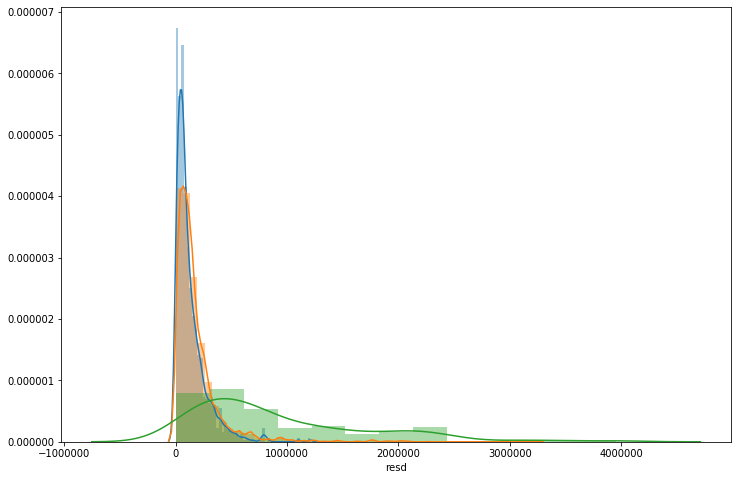

In [32]:
plt.figure(figsize=(12,8))
sns.distplot(k) # 강원도 blue
sns.distplot(t) # 대구 orange
sns.distplot(s) # 서울 green
plt.show()

|잔차| 상위 5% : 추정이 잘 안된 480개 데이터
- 강원도 15개 -> 전체 강원도 데이터의 0.55% 차지 -> 추정이 잘된 지역
- 서울 25개 -> 전체 서울 데이터의 22% 차지 -> 추정이 잘 안된 지역
- 대구 440개 -> 전체 대구 데이터의 6.5% 차지 -> 추정이 잘 지역

|잔차| 하위 5% : 추정이 잘 된 480개 데이터
- 강원도 206개 -> 전체 강원도 데이터의 7.6%차지 -> 추정이 잘 된 지역
- 대구 274개 -> 전체 대구 데이터의 4% 차지 -> 추정이 잘된 지역

유난히 서울 예측이 잘 안됨
- 제공받은 데이터 : 강원도, 대구에 비해 n이 적었음 + 종로구 데이터만 제공받음
- 더미 변수로 서울 특성을 반영하고자 하였으나, '교통 편의시설 등 각종 인프라'가 집중된 점은 반영하지 못함.

한계
- 서울, 대구의 예측력을 보완하고자 아파트 브랜드/시공사 변수를 추가하려 했으나, 변수 추출에 어려움이 있어 못했다. 해당 데이터가 있었다면 더 좋은 예측력을 기대할 수 있었을 것이다.
- 제공된 데이터 셋에서 y값과 1대1 labeling이 되지 않아 사용할 수 없었던 데이터들이 존재한다. 이러한 데이터들을 사용할 수 있는 모델이나 데이터 전처리 방법을 사용하지 못하였다. 